## Biblioteka

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
import eli5

from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier

from sklearn.model_selection import GroupKFold
from ml_metrics import mae

import re
import sys

import mlflow

import xgbfir

import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial

import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict

## Wczytujemy dane

In [2]:
ls ../input

../input@


In [3]:
df_train = pd.read_hdf('../input/tram.train.h5')
df_test = pd.read_hdf('../input/tram.test.h5')


print(df_train.shape)
df_train.sample(10)

(175986, 11)


,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num
198055,198055,0,2018-07-27 13:14:18,136,Bronowice Wiadukt,24,Bronowice Małe,2018-07-27 13:14:00,6.352185e+18,6351558574046752009,27.0
13484,13484,120,2018-07-23 10:42:27,612,Borsucza,22,Walcownia,2018-07-23 10:40:00,6.352185e+18,6351558574044891398,7.0
30626,30626,0,2018-07-23 16:42:39,1263,Mały Płaszów,11,Czerwone Maki P+R,2018-07-23 16:43:00,6.352185e+18,6351558574044662032,1.0
35732,35732,60,2018-07-23 18:20:00,363,Hala Targowa,1,Salwator,2018-07-23 18:19:00,6.352185e+18,6351558574044354826,24.0
18829,18829,120,2018-07-23 12:40:34,679,Ćwiklińskiej,9,Nowy Bieżanów P+R,2018-07-23 12:38:00,6.352185e+18,6351558574044625159,35.0
131280,131280,0,2018-07-25 20:09:02,2811,Muzeum Lotnictwa,4,Bronowice Małe,2018-07-25 20:09:00,6.352185e+18,6351558574044486413,15.0
19318,19318,240,2018-07-23 12:51:30,1262,Rzebika,11,Mały Płaszów,2018-07-23 12:47:00,6.352185e+18,6351558574044678410,21.0
20171,20171,0,2018-07-23 13:10:51,561,Lipska,20,Mały Płaszów,2018-07-23 13:10:00,6.352185e+18,6351558574044870923,17.0
211169,211169,60,2018-07-27 18:48:44,408,Rondo Czyżyńskie,4,Wzgórza K.,2018-07-27 18:47:00,6.352185e+18,6351558574046326028,23.0
46852,46852,120,2018-07-23 23:19:09,408,Rondo Czyżyńskie,1,Wzgórza K.,2018-07-23 23:17:00,6.352185e+18,6351558574044391697,20.0


## Przygotowujemy `X` i `y`

In [4]:
df_train= df_train[ df_train.delay < 600 ]#usuwam outliers
df = pd.concat([df_train, df_test])
df.shape

(307919, 11)

In [5]:
df.isna().sum()

id                   0
delay           132166
datetime        132166
stop                 0
stop_name            0
number               0
direction            0
planned_time         0
vehicle_id           0
trip_id              0
seq_num           2382
dtype: int64

In [6]:
#zamieniam nan w seq_num
df.seq_num = df.seq_num.fillna(df.seq_num.median())


## Features

In [7]:
#factorize stop name

df["stop_name_cat"] = df["stop_name"].factorize()[0]

#transformacje dat

df["plan_date"]= df["planned_time"].str.split(" ", n = 1, expand = True)[0]
df["plan_time"]= df["planned_time"].str.split(" ", n = 1, expand = True)[1]
df["plan_hour"]= df["plan_time"].str.split(":", n = 1, expand = True)[0].astype('int64')

#add hour cat
df['plan_hour_cat'] = pd.factorize( df['plan_hour'] )[0]

#factorize stop
df['stop_cat'] = pd.factorize( df['stop'] )[0]

#factorize direction

df['direction_cat'] = pd.factorize( df['direction'] )[0]

#factorize number
df['number_cat'] = pd.factorize( df['number'] )[0]

#add stop and seq
df['stop_sequance'] = df.apply(lambda x: "{}-{}".format(x['stop'],x['seq_num']),axis=1)
df['stop_seq_cat'] = pd.factorize( df['stop_sequance'] )[0]

#add dir and num
df['dir_num'] = df.apply(lambda x: "{}-{}".format(x['direction'],x['number']),axis=1)
df['dir_num_cat'] = pd.factorize( df['dir_num'] )[0]


#trip
df['trip_cat'] = df['trip_id'].astype('str').str[12:]
df['trip_cat2'] = np.log(df['trip_id'].astype('int64'))
df['trip_cat3'] = df['trip_cat2'].map(lambda x: 1 if x <15.5 else 0)


#dzien tygodnia
df["actual_time"]= df["datetime"].str.split(" ", n = 1, expand = True)[1]
df['actual_time_asdate'] = pd.to_datetime(df['datetime'])
df['planned_time_asdate'] = pd.to_datetime(df['planned_time'])
df['plan_weekday'] = df['planned_time_asdate'].dt.day_name()
df['weekday'] = df['plan_weekday'].map(lambda x: 1 if x in ("Monday","Tuesday") else 0)


df['rush_hour'] = df['plan_hour'].map(lambda x: 1 if x in (15,16,17) else 0)
df['rush_hour2'] = df['plan_hour'].map(lambda x: 1 if x in (4,5,6) else 0)

df['pora'] = pd.cut(df['plan_hour'], bins=[0,1,7,14,18,24],labels=["polnoc","rano","dzien","szczyt","wieczor"])
df['pora_cat']=pd.factorize( df['pora'] )[0]

df['trasa'] = pd.cut(df['seq_num'], bins=[0,10,20,30],labels=["start","środek","koniec"])
df['trasa_cat']=pd.factorize( df['trasa'] )[0]


In [8]:
#logs

df['seq_rush_log'] = np.log((df['seq_num'])*(df['rush_hour']+1)+50)

df['dir_rush_log'] = np.log((df['direction_cat'])*(df['rush_hour']+1)+50)

df['num_rush_log'] = np.log((df['number_cat'])*(df['rush_hour']+1)+50)

df['number_seq_log'] = np.log(df['seq_num']*(df['number_cat']+1)+50)

df['stop_seq_log'] = np.log((df['stop_cat']+1)*df['seq_num']+50)

df['dir_seq_num_log'] = np.log((df['direction_cat']+1)*df['seq_num']*(df['number_cat']+1)+50)

df['num_hour_seq_log'] = np.log((df['number_cat']+1)*df['seq_num']*(df['plan_hour_cat']+1)+50)

df['number_stop_log'] = np.log((df['stop_cat']+1)*(df['number_cat']+1)+50)

df['seq_hour_log'] = np.log((df['seq_num'])*(df['plan_hour_cat']+1)+50)

df['num_hour_log'] = np.log((df['number_cat']+1)*(df['plan_hour_cat']+1)+50)

In [9]:
#faktyczne opóźnienie w sek i log
df["delay_seconds"]= df['actual_time_asdate'] - df['planned_time_asdate']
df["delay_seconds_total"]=df["delay_seconds"].dt.total_seconds()
df["delay_log"] = np.log(df['delay_seconds_total']+250) #target+offset


<AxesSubplot:>

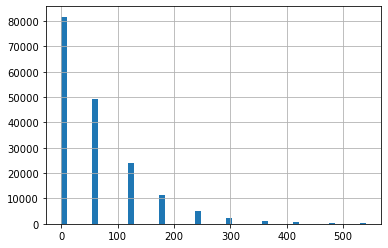

In [10]:
df.delay.hist(bins=50)

<AxesSubplot:>

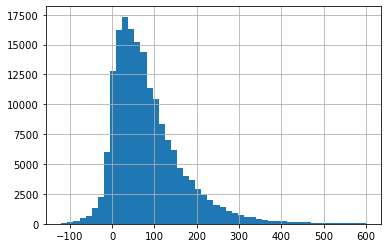

In [11]:
df.delay_seconds_total.hist(bins=50)

<AxesSubplot:>

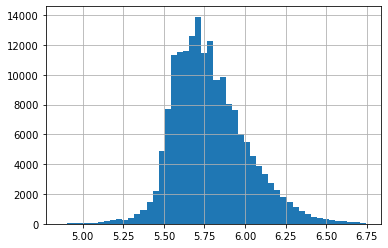

In [12]:
df.delay_log.hist(bins=50)


## Merges

In [13]:
df_pom = df[ df["delay"].notnull() ].copy()

df_hour_delay = df_pom[["plan_hour", "delay_log"]].groupby(["plan_hour"]).agg(
    mean_hour_delay=("delay_log", "mean"),
    median_hour_delay=("delay_log", "median"),

    
).reset_index()



In [14]:
df_hour_prob = df_pom[["plan_hour", "delay"]].groupby("plan_hour").agg(
    prob_zeros_hour_delay=("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()



In [15]:
df_stop_delay = df_pom[["stop_name", "delay_log"]].groupby(["stop_name"]).agg(
    mean_stop_delay=("delay_log", "mean"),
    median_stop_delay=("delay_log", "median")

).reset_index()



In [16]:
df_stop_delay = df_pom[["stop_name", "delay_log"]].groupby(["stop_name"]).agg(
    mean_stop_delay=("delay_log", "mean"),
    median_stop_delay=("delay_log", "median")

).reset_index()



In [17]:
df_stop_prob = df_pom[["stop_name", "delay"]].groupby("stop_name").agg(
    prob_zeros_stop_delay=("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()



In [18]:
df_dir_delay = df_pom[["direction", "delay_log"]].groupby(["direction"]).agg(
    mean_dir_delay=("delay_log", "mean"),
    median_dir_delay=("delay_log", "median"),

).reset_index()



In [19]:
df_dir_prob = df_pom[["direction", "delay"]].groupby("direction").agg(
    prob_zeros_dir_delay=("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()



In [20]:
df_seq_num_delay = df_pom[["seq_num", "delay_log"]].groupby(["seq_num"]).agg(
    mean_seq_num_delay=("delay_log", "mean"),
    median_seq_num_delay=("delay_log", "median"),

).reset_index()



In [21]:
df_seq_num_prob = df_pom[["seq_num", "delay"]].groupby("seq_num").agg(
    prob_zeros_seq_num_delay=("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()



In [22]:
df_num_prob = df_pom[["number", "delay"]].groupby("number").agg(
    prob_zeros_num_delay=("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()


In [23]:
df_num_delay = df_pom[["number", "delay_log"]].groupby(["number"]).agg(
    mean_num_delay=("delay_log", "mean"),
    median_num_delay=("delay_log", "median"),

).reset_index()

In [24]:
#PORA
df_pora_prob = df_pom[["pora", "delay"]].groupby("pora").agg(
    prob_pora_delay=("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()

In [25]:
df = pd.merge(df, df_hour_delay, on=["plan_hour"], how="left")
df = pd.merge(df, df_hour_prob, on=["plan_hour"], how="left")

df = pd.merge(df, df_stop_delay, on=["stop_name"], how="left")
df = pd.merge(df, df_stop_prob, on=["stop_name"], how="left")

df = pd.merge(df, df_seq_num_delay, on=["seq_num"], how="left")
df = pd.merge(df, df_seq_num_prob, on=["seq_num"], how="left")

df = pd.merge(df, df_dir_delay, on=["direction"], how="left")
df = pd.merge(df, df_dir_prob, on=["direction"], how="left")

df = pd.merge(df, df_num_delay, on=["number"], how="left")
df = pd.merge(df, df_num_prob, on=["number"], how="left")

df = pd.merge(df, df_pora_prob, on=["pora"], how="left")


In [26]:
#prawdopodobieństwa
df["prob1"] = df["prob_zeros_num_delay"]*df["prob_zeros_dir_delay"]*df["prob_zeros_stop_delay"]*df["prob_zeros_hour_delay"]
df["prob2"] = df["prob_zeros_num_delay"]*df["prob_zeros_dir_delay"]
df["prob3"] = df["prob_zeros_num_delay"]*df["prob_zeros_stop_delay"]
df["prob4"] = df["prob_zeros_dir_delay"]*df["prob_zeros_stop_delay"]
df["prob5"] = df["prob_zeros_num_delay"]*df["prob_zeros_dir_delay"]*df["prob_zeros_stop_delay"]
df["prob6"] = df["prob_zeros_dir_delay"]*df["prob_zeros_stop_delay"]*df["prob_zeros_hour_delay"]

df["probh1"] = df["prob_zeros_num_delay"]*df["prob_pora_delay"]
df["probh2"] = df["prob_zeros_dir_delay"]*df["prob_pora_delay"]
df["probh3"] = df["prob_zeros_stop_delay"]*df["prob_pora_delay"]



### FEATES SELECTION

In [27]:
feats = df.select_dtypes("number").columns
black_list = ["id","delay_pom","delay","delay_pred","trip_id","delay_seconds_total","delay_seconds","vehicle_id","delay_log"]
feats = [x for x in feats if x not in black_list]
feats = ["rush_hour","seq_num","number","direction_cat","stop","stop_name_cat","number_seq_log",
        "dir_num_cat","stop_seq_log","dir_seq_num_log",
        "trasa_cat","rush_hour2","plan_hour_cat","pora_cat",
         "prob2","prob4","median_num_delay",
         "traffic_loc","no_delays_stops"
        
         ] 


feats


['rush_hour',
 'seq_num',
 'number',
 'direction_cat',
 'stop',
 'stop_name_cat',
 'number_seq_log',
 'dir_num_cat',
 'stop_seq_log',
 'dir_seq_num_log',
 'trasa_cat',
 'rush_hour2',
 'plan_hour_cat',
 'pora_cat',
 'prob2',
 'prob4',
 'median_num_delay']


## X i Y

In [28]:
df_train = df[ df["delay"].notnull() ].copy()
df_test = df[ df["delay"].isnull() ].copy()

X_train = df_train[feats].values
y_train = df_train["delay_log"].values
X_test = df_test[feats].values

X_train.shape, y_train.shape, X_test.shape

((175753, 17), (175753,), (132166, 17))


## Function

In [29]:
def get_or_create_experiment(name):
    experiment = mlflow.get_experiment_by_name(name)
    if experiment is None:
        mlflow.create_experiment(name)
        return mlflow.get_experiment_by_name(name)
    
    return experiment

def _eid(name):
    return get_or_create_experiment(name).experiment_id

xgb_params = {
        'max_depth': 20,
        'colsample_bytree': 0.830773895295601,
        'learning_rate': 0.06410030992125423,
        'subsample': 0.7009297205524789,
        'random_state': 4050,
        'min_child_weight': 6,
        'reg_alpha': 1.27696031271454,
        'reg_lambda': 0.7448132213814874,
        'n_estimators': 100,
        'objective': 'reg:squarederror'
}

def get_models(use_dummy=False):
    
    models = [('dummy', DummyRegressor(strategy='median'))] if use_dummy else []

    models += [
        #('decision tree', DecisionTreeRegressor(max_depth=5)),
        #('random forest', RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0)),
        ('xgboost', xgb.XGBRegressor(**xgb_params)),
        #('catboost', ctb.CatBoostRegressor(n_estimators=100, max_depth=5, random_state=0, verbose=False)),
        #('lightgbm', lgb.LGBMRegressor(n_estimators=100, max_depth=5, random_state=0)),
    ]
    
    return models

        
def run_experiment(model_name, model, X, y, exp_name, cv=5, scoring=["neg_mean_absolute_error"], tags={}, params={}, template_for_run_name="{}"):
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    
    model_str = str(model).split("(")[0]

    with mlflow.start_run(experiment_id=_eid(exp_name), run_name=template_for_run_name.format(model_name)) as run:
        tags["model"] = model_str
        tags["X.shape"] = X.shape
        tags["y.shape"] = y.shape
        
        mlflow.set_tags(tags)
        result = cross_validate(model, X, y, scoring=scoring, return_train_score=True, return_estimator=True)
        model.fit(X, y)
        y_pred = model.predict(X)
        estimator = result.get("estimator")
        if estimator:
            del result["estimator"]
        
        ### TRACK PARAMS
        params.update(model.get_params()) 
        params.update(tags)
        params.update({
            "cv": str(cv),
        })
        mlflow.log_params(params)

        ### TRACK METRICS
        metrics = {}
        metrics.update({"avg_{}".format(x): np.mean(result[x]) for x in result})
        metrics.update({"std_{}".format(x): np.std(result[x]) for x in result})

        mlflow.log_metrics(metrics)

        
        print("model={}, {}\n".format(model_name, metrics))

       

### MODEL

In [30]:
for model_name, model in get_models():
    tags = {}
    params = {}
    run_experiment(model_name, model, X_train, y_train, exp_name="tram", tags=tags, params=params)

2021/11/04 10:55:21 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



model=xgboost, {'avg_fit_time': 22.68145332336426, 'avg_score_time': 0.1736599922180176, 'avg_test_neg_mean_absolute_error': -0.14112500528282124, 'avg_train_neg_mean_absolute_error': -0.13243143125591622, 'std_fit_time': 0.3489585498911379, 'std_score_time': 0.0015657268511887394, 'std_test_neg_mean_absolute_error': 0.002799965397009125, 'std_train_neg_mean_absolute_error': 0.0007780534841360593}



### Wykresy

<AxesSubplot:title={'center':'Feature Importance'}>

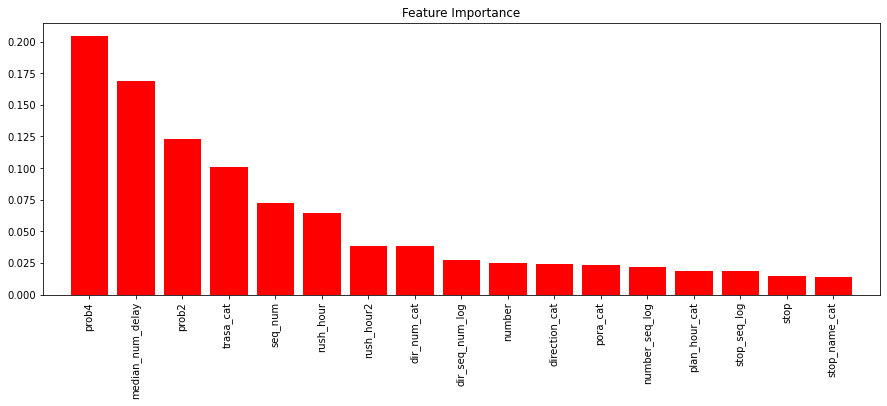

In [31]:
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))

In [32]:
eli5.show_weights(model, feature_names=feats)

Weight,Feature
0.2047,prob4
0.1692,median_num_delay
0.1226,prob2
0.1006,trasa_cat
0.0726,seq_num
0.0648,rush_hour
0.0387,rush_hour2
0.0381,dir_num_cat
0.0274,dir_seq_num_log
0.0252,number


In [33]:
xgbfir.saveXgbFI(model, feature_names=feats, OutputXlsxFile='cechy.xlsx')

In [34]:
pd.read_excel('cechy.xlsx', 'Interaction Depth 0')

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,prob4,4890.457022,3973,156.964383,0.039508,1.230923,4193.020351,1,4,1,4,1,1,2.000000,76.730179,12.010823
1,seq_num,2146.273655,4918,92.243179,0.018756,0.436412,1075.192272,2,2,3,11,5,2,4.166667,78.943880,12.325539
2,prob2,978.105697,1326,55.752710,0.042046,0.737636,372.920484,3,12,10,3,3,3,5.666667,73.921569,10.757919
3,plan_hour_cat,926.852854,8140,120.626819,0.014819,0.113864,166.405953,4,1,2,15,14,5,6.833333,81.455405,12.615479
4,median_num_delay,576.935474,567,27.228112,0.048021,1.017523,182.986152,5,16,14,1,2,4,7.000000,68.509700,10.179894
5,dir_seq_num_log,513.469294,3117,76.392826,0.024508,0.164732,54.412820,6,8,6,8,9,9,7.666667,77.584857,11.975297
6,number_seq_log,460.940244,3475,77.078700,0.022181,0.132645,51.936330,7,6,5,10,13,10,8.500000,77.175827,12.202878
7,rush_hour,396.146132,1017,29.754346,0.029257,0.389524,131.273409,8,14,13,6,6,6,8.833333,81.237955,12.377581
8,stop,382.749694,4236,60.929892,0.014384,0.090356,28.638997,9,3,8,17,16,13,11.000000,78.041785,12.225449
9,stop_seq_log,375.440679,3356,88.549648,0.026385,0.111871,61.343309,10,7,4,7,15,7,8.333333,78.416567,12.259237


In [35]:
pd.read_excel('cechy.xlsx', 'Interaction Depth 1')

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,prob4|seq_num,5631.651051,800,37.658974,0.047074,7.039564,2678.569994,1,11,1,15,3,1,5.333333,74.620000,11.853750
1,prob4|prob4,4244.085527,527,31.703270,0.060158,8.053293,2009.631252,2,31,3,7,2,2,7.833333,74.681214,11.381404
2,prob2|seq_num,1379.393646,282,13.273166,0.047068,4.891467,562.488459,3,53,18,16,8,3,16.833333,70.382979,10.411348
3,median_num_delay|seq_num,1062.676525,163,7.836462,0.048076,6.519488,406.722382,4,71,44,12,5,4,23.333333,64.374233,9.564417
4,seq_num|seq_num,941.034748,383,5.194756,0.013563,2.457010,254.136045,5,37,65,80,13,5,34.166667,80.334204,12.167102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,number|stop,62.998260,260,2.119589,0.008152,0.242301,1.225164,96,57,88,96,77,100,85.666667,77.953846,12.438462
96,dir_seq_num_log|trasa_cat,62.744922,26,1.043948,0.040152,2.413266,19.133128,97,99,99,22,14,41,62.000000,69.000000,11.961538
97,stop_name_cat|stop_name_cat,62.221078,333,7.209647,0.021651,0.186850,2.657403,98,42,49,56,92,97,72.333333,79.564565,12.072072
98,number_seq_log|rush_hour,61.951528,139,1.724293,0.012405,0.445694,6.965164,99,77,94,85,47,67,78.166667,79.863309,11.884892


In [36]:
pd.read_excel('cechy.xlsx', 'Interaction Depth 2')

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,prob4|prob4|seq_num,4832.790604,161,15.195553,0.094382,30.017333,1448.155613,1,35,1,8,9,1,9.166667,65.099379,10.229814
1,prob2|prob4|seq_num,2694.425868,71,6.117531,0.086162,37.949660,768.015872,2,57,5,9,8,2,13.833333,62.507042,9.464789
2,median_num_delay|prob4|seq_num,1930.715139,46,3.951446,0.085901,41.972068,507.608275,3,64,18,10,6,4,17.500000,58.347826,8.500000
3,prob4|prob4|trasa_cat,1916.329083,15,2.204975,0.146998,127.755272,696.716505,4,88,48,3,2,3,24.666667,45.066667,9.133333
4,prob4|seq_num|seq_num,1800.632964,96,1.858668,0.019361,18.756593,476.020176,5,44,55,61,16,5,31.000000,76.854167,12.739583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,number_seq_log|plan_hour_cat|stop_seq_log,80.635532,303,3.414884,0.011270,0.266124,1.987431,96,14,24,81,96,98,68.166667,82.300330,13.118812
96,plan_hour_cat|prob4|rush_hour,79.295484,66,2.631024,0.039864,1.201447,27.569555,97,60,36,28,59,41,53.500000,81.333333,12.969697
97,dir_seq_num_log|plan_hour_cat|stop,79.260526,294,1.787618,0.006080,0.269594,0.818548,98,15,59,96,95,100,77.166667,82.068027,12.945578
98,pora_cat|prob4|stop_seq_log,77.593567,48,0.405235,0.008442,1.616533,13.864784,99,63,98,88,52,64,77.333333,77.895833,11.812500


In [37]:
def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
                
        return mean_absolute_error(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


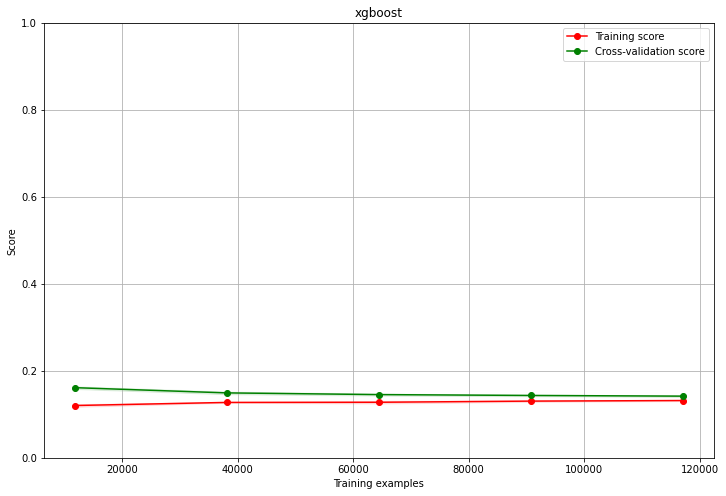

In [38]:
plt = plot_learning_curve(model, model_name, X_train, y_train, ylim=(0,1), cv=3)
plt.show()

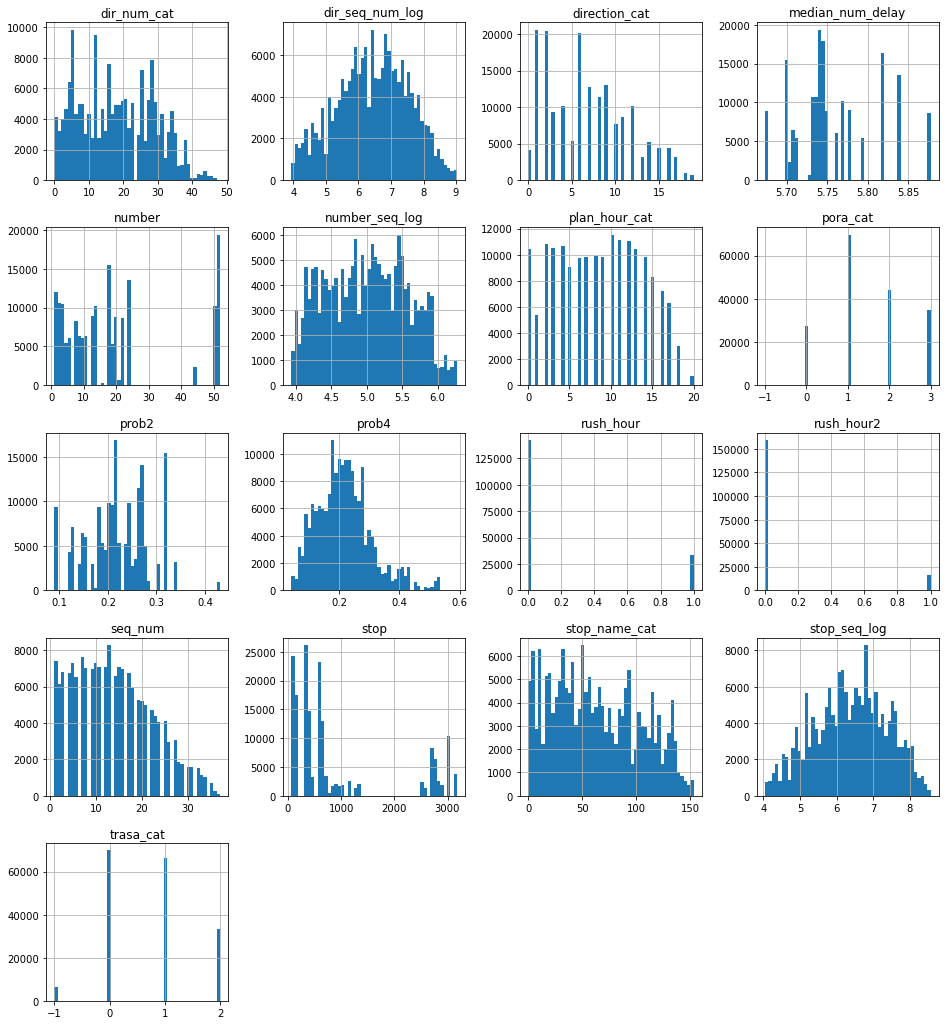

In [40]:
df_train[feats].hist(figsize=(16,18),bins=50);

### ZAPIS MODELU

In [45]:
df_train["delay_pred_log"] = model.predict(X_train)
df_test["delay_pred_log"] = model.predict(X_test)

df_test["delay_secs"]=np.exp(df_test["delay_pred_log"])-250
df_test["delay"] = df_test.delay_secs.map(lambda x: 60*math.floor(x/60) )
df_test["delay"][ df_test["delay"]<0 ] = 0


<ipython-input-45-1c9bb0af52fb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["delay"][ df_test["delay"]<0 ] = 0


In [46]:
df_test[ ["id", "delay"] ].to_csv('../output/0211.csv', index=False) 

### HYPEROPT

In [42]:
#hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial

X = X_train 
y = y_train 

def objective(space):
        

    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': 0,
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    
    print("params: ", xgb_params)
    
    cv = KFold(n_splits=5)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = mean_absolute_error(y_test, y_pred)
        scores.append( score )
        
    print(np.mean(scores), np.std(scores))
    
    return {'loss':np.mean(scores), 'status': STATUS_OK }



space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}



trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=5),
            max_evals=50,
            trials=trials)

print("The best params: ", best_params)

params:                                               
{'max_depth': 12, 'colsample_bytree': 0.8788730426799101, 'learning_rate': 0.09047926512254631, 'subsample': 0.9377302390565074, 'random_state': 0, 'min_child_weight': 5, 'reg_alpha': 1.4211629696519659, 'reg_lambda': 0.7036164290981545, 'n_estimators': 100, 'objective': 'reg:squarederror'}
0.14159621173275014                                   
0.0030492561354016584                                 
params:                                                                            
{'max_depth': 9, 'colsample_bytree': 0.9013189752717634, 'learning_rate': 0.12909415976647287, 'subsample': 0.7610830650936977, 'random_state': 0, 'min_child_weight': 5, 'reg_alpha': 1.11389965187331, 'reg_lambda': 0.9115854180191965, 'n_estimators': 100, 'objective': 'reg:squarederror'}
0.14159117479205469                                                                
0.002981550212902789                                                               
pa